In [34]:
#mm ... small edits by M. M.
# (#aaa #aaaa #aaaa ... "attention", "importance" marks, just for M. M.)
#mm-todo-tweak #aaaa

#mm
import torch
torch.set_printoptions(profile='short')
#%precision 2
# https://pytorch.org/docs/stable/generated/torch.set_printoptions.html
#torch.set_printoptions(precision=0)
torch.set_printoptions(threshold=7)
torch.set_printoptions(edgeitems=3)


Karpathy has CHALLENGED US TO BEAT HIS VALIDATION LOSS OF 2.2 (dev set loss).
WE MUST!!! ONWARDS!!!! (We'll change the hyperparameters hbehehe)
Also, he said we should be able to read a good chunk of the paper by now, so let's try that too :D

Anyways, for this, let's make nice functions where we can change all the hyperparameters.
Batch size, # neurons, C embedding size, lr, ... 

# E01: Beat Big K's 2.2 validation (dev set) loss

In [35]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# Read words and generate our char <-> int functions
words = open('../names.txt', 'r').read().splitlines() # Read everything
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)} # string to integer
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()} # int to string

words[:8] # woo


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

Making our dataset splits

In [37]:
def generate_dataset(words, block_size, doprint=False):
	"""returns X, Y datasets based on words list
	block_size: context length: how many characters do we take to predict the next one?
	"""
	X, Y = [], []

	for w in words:
		if doprint:
			print(w)	
		context = [0] * block_size # this would make [0, 0, ...] based on block_size

		for ch in w + '.': 
			ix = stoi[ch] # index of char
			X.append(context)
			Y.append(ix)
			
			if doprint:
				print(''.join(itos[i] for i in context), '------>', itos[ix])
			context = context[1:] + [ix] # [0,0,0] -> [0,0, ix] like a rolling effect

	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

In [38]:
### Hyperparameters!!! CHANGE STUFF HERE

#mm-todo-tweak #aaaa

block_size = 3 # num of past chars to use to predict next char
embedding_size = 2 #10
num_neurons = 100 # 250 # for layer 1 
batch_size = 48

In [39]:
# Generate our train, dev, and test loss. We'll be trying to get dev loss < 2.2
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
print(f'number of words: {len(words)}')

Xtr, Ytr = generate_dataset(words[:n1], block_size)
Xdev, Ydev = generate_dataset(words[n1:n2], block_size)
Xte, Yte = generate_dataset(words[n2:], block_size)
# Of course, the sizes are way more massive than # word examples because these are the examples from the words (char stuff), not the words themselves.

number of words: 32033
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Next up, initialisation of our model! I.e, we'll initialise the weights.

In [40]:
g = torch.Generator().manual_seed(2147483647) # This will be a 'global' generator
def generate_parameters(block_size, embedding_size, num_neurons):
	# We booosting our hidden layer size
	C = torch.randn(27, embedding_size, generator=g) # Generate embedding of characters, e.g (27,10)

	W1 = torch.randn((embedding_size * block_size, num_neurons), generator=g) # first weights takes input from 
	b1 = torch.randn(num_neurons, generator=g)
	W2 = torch.randn((num_neurons, 27), generator=g)
	b2 = torch.randn(27, generator=g)
	parameters = [C, W1, b1, W2, b2] # for easy summing parameters

	for p in parameters:  # Turn on requires grad for our parameter matrices
		p.requires_grad = True
		
	print("Number of parameters in total:", sum(p.nelement() for p in parameters)) # num of parameters in total

	return parameters
parameters = generate_parameters(block_size, embedding_size, num_neurons)
C, W1, b1, W2, b2 = parameters
C.shape, W1.shape


Number of parameters in total: 3481


(torch.Size([27, 2]), torch.Size([6, 100]))

Just as a consolidation bit, we'd be wanting to do this to push it through the first layer
```
C[Xtr] @ W1 + b1 # -> doesn't work, as C[Xtr].shape -> torch.Size([182484, 3, 10]) || Each example has 3 inputs, and each char input has an embedding size of 10.
W1 -> torch.Size([30, 200]). 
```
We want to flatten the embedded stuff so each example just reads as a 30 length vector (or w.e the size of the thingy is), i.e ([# examples, block*embedding sizes ]). We do this via: 
```
C[Xtr].view((-1, block_size*embedding_size)).shape -> torch.Size([182484, 30])
C[Xtr].view((-1, block_size*embedding_size)) @ W1 + b1 # works! -> torch.Size([182484, 200]). Yay!
```

## And now we'll have to do gradient descent on the model. 

(this is called the training loop or whatever)
If I remember well,

0th step; we can minibatch! To make the mfer run faster, even at some loss of accuracy of the gradient to descend, it's still much better overall.

#### First step, is forward passing.
 We get the training data (specifically, training data from minibatch). We embed it, and flatten that embedding (using the efficient .view(..)), and then 'run it through' the layers by doing our activation on it. Then we run it through the second layer (our final one), giving us the logits.

We can get the loss straight up by doing F.cross_entropy, or we can get the probability dist. by softmaxing it. (And then you could work out loss. Remember, these functions are doing very simple things we've already done!! -- they just exp, normalise weights, and then get the negative loss likelihood).

#### The backwards pass
Make sure to set all our grads to 0.
Then we just  loss.backward(), propagating through every operation done and getting it's gradient w.r.t loss

#### Updating weights
And we just update the weights now :D 


In [41]:
#mm
#aaaa
# add embedding projector data to summary
##writer.add_embedding(P.transpose(1,0)   , metadata= ['@']+chars )
                    # ,     global_step=n27)

#writer.flush()
## close writer
##writer.close()


In [42]:
# Implemented hardcode first

def train(X: torch.Tensor, Y: torch.Tensor, num_steps: int, block_size: int, embedding_size: int, batch_size:int,  parameters, doTrack = False): 
	"""_summary_

	Args:
		X (torch.Tensor): X dataset to train on (train with our Xtr!)
		Y (torch.Tensor): Y dataset for labels
		num_steps (int): Number of times to go through loop
		block_size (int): Context length; # characters used to predict next one
		embedding_size (int): Size of embedding for the characters
		parameters (_type_): param


	"""
	C, W1, b1, W2, b2 = parameters
	# track stats (optional)
	stepi, lossi = [], []

	# Main training loop
	for i in range(num_steps):
		ix = torch.randint(0, X.shape[0], (32,)) # We get {minibatch_size} random ints from size of 0- training set
		
		# forward pass -- on our minibatch :o !!!!
		emb = C[X[ix]] # (32,3,2) here || (minibatch_size, block_size, embed size))
		# print(f'{emb.shape=}')
		h = torch.tanh(emb.view(-1, block_size*embedding_size) @ W1 + b1) # We do the whole embed flatten, push it through layer 1, and tanh activation on it. All elements of h is between [-1, 1]
		logits = h @ W2 + b2 # (32, 27)


		loss = F.cross_entropy(logits, Y[ix]) # Does the epic normalisation stuff for us 
		# print(f'Loss during this minibatch loop: {loss=}')

		# backward pass - zero grad, backprop
		for p in parameters:
			p.grad = None
		loss.backward()

		# update
		# lr = lrs[i]
        
#mm-todo-tweak #aaaa
       
		#lr = 0.1 if i < 100000 else 0.01
		#lr = 0.01 if i < 100000 else 0.01
		#lr = 0.5 if i < 100000 else 0.01
		lr = 0.2 if i < 100000 else 0.01
		for p in parameters:
			p.data += -lr * p.grad

		# track stats (optional part)
		if doTrack:
#writer.add_scalar("loss", loss, i)
			writer.add_scalar(  "loss3",  loss.log10().item(),i)  #mm
			stepi.append(i)
			lossi.append(loss.log10().item())

	return loss, [stepi, lossi] # Not needed, I'm just putting it here because why not

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("d:/ai/makemore_ex_CHALLENGE")

#mm

#train_loss, track_stats = train(Xtr, Ytr, 2*10**5, block_size, embedding_size, batch_size, parameters, doTrack=False) 
train_loss, track_stats = train(Xtr, Ytr, 200_000, block_size, embedding_size, batch_size, parameters, doTrack=True) 
print(train_loss)
writer.close()


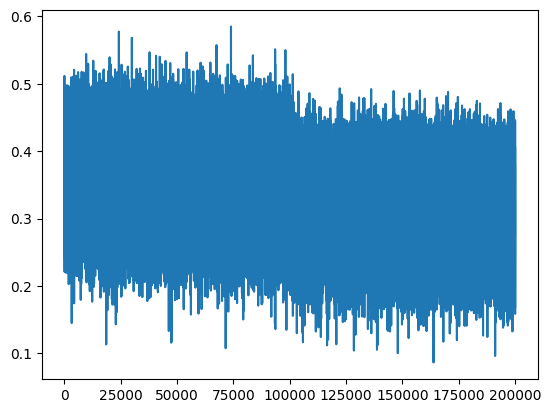

In [19]:
plt.plot(track_stats[0], track_stats[1]) # stepi, lossi

### Great! Now let's evaluate our model!
(Our model is our parameters :ooooo)
It also comes to my attention now that maybe setting the hyperparametrs as constants  would be better so I didn't have to feed in every goddamn thing into every function

In [20]:
def evaluate_loss(X, Y, block_size, embedding_size, parameters):
	C, W1, b1, W2, b2 = parameters
	emb = C[X] # (X.shape[0],3,2) here -- whole set in this case
	h = torch.tanh(emb.view(-1, block_size*embedding_size) @ W1 + b1) # (blah, 100)

	logits = h @ W2 + b2 # (32, 27)

	loss = F.cross_entropy(logits, Y) # Does the epic normalisation stuff
	print(f'{loss=}')
	return loss

In [21]:
train_loss = evaluate_loss(Xtr, Ytr, block_size, embedding_size, parameters)
dev_loss = evaluate_loss(Xdev, Ydev, block_size, embedding_size, parameters)  ### YOOOOO 2.18 POOOOOG


loss=tensor(2.08, grad_fn=<NllLossBackward0>)
loss=tensor(2.14, grad_fn=<NllLossBackward0>)


In [22]:
test_loss = evaluate_loss(Xte, Yte, block_size, embedding_size, parameters) ## POGGING RN


loss=tensor(2.13, grad_fn=<NllLossBackward0>)


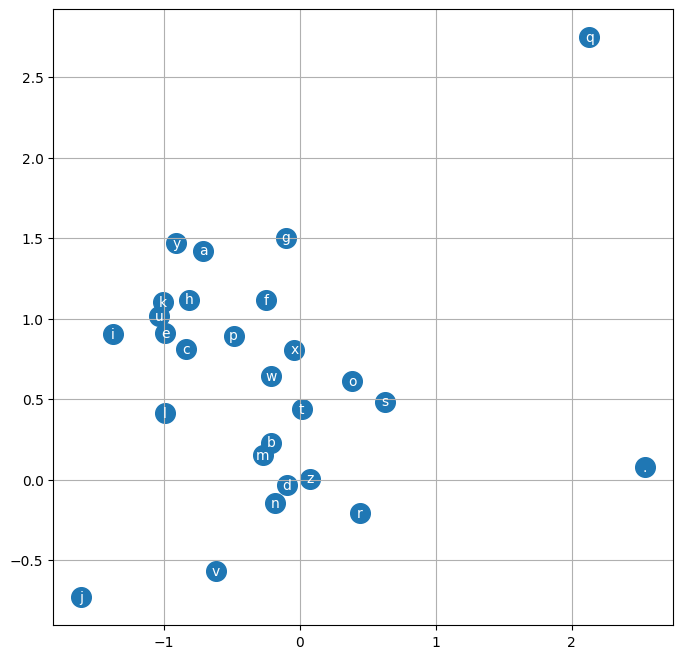

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### Sampling!

In [24]:
def sample(num_words):
	# sample from the model
	g = torch.Generator().manual_seed(2147483647 + 10)

	for _ in range(num_words):
		
		out = []
		context = [0] * block_size # initialize with all ...
		while True:
			emb = C[torch.tensor([context])] # (1,block_size, embedding_size)
			h = torch.tanh(emb.view(1, -1) @ W1 + b1)
			logits = h @ W2 + b2
			probs = F.softmax(logits, dim=1) # exponentiates, normalises (sum to one). It's like entropy, but goes from logits -> prob distr, instead of logits -> loss
			ix = torch.multinomial(probs, num_samples=1, generator=g).item()
			context = context[1:] + [ix]
			out.append(ix)
			if ix == 0:
				break
			
		print(''.join(itos[i] for i in out))

In [25]:
sample(20)

carmah.
amelle.
khy.
mili.
tatyannah.
sae.
mahibelle.
saha.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
joce.
quint.
sulisea.
jadbi.
wazelogiearisi.
jacee.
dusabee.


#### Random stuff below

In [26]:
testing = torch.randn((4,4,4 ))
testing

tensor([[[ 1.08,  0.12,  0.94,  0.48],
         [-1.51, -1.58, -0.60, -1.02],
         [ 0.58,  0.58,  0.70, -0.77],
         [-0.01, -1.51, -3.05, -1.97]],

        [[-1.29,  0.11,  0.03, -1.84],
         [-0.15, -1.35,  0.28, -0.60],
         [ 1.28,  0.78, -0.53, -1.67],
         [-0.28,  0.66, -0.53,  2.02]],

        [[ 1.44,  0.32,  0.64, -0.18],
         [-0.14,  1.03, -0.58,  1.57],
         [ 0.57, -1.28, -1.04,  0.94],
         [ 0.67,  1.83, -0.19,  1.25]],

        [[ 0.95, -0.44,  0.54,  0.29],
         [-0.15, -0.96, -0.69,  1.34],
         [ 0.36, -0.17,  0.29, -0.32],
         [ 2.05, -0.04,  1.38, -0.69]]])

In [356]:
# See below:
"""
| |
| |
| |
| |


Dim 0 sums in the direction of that. Move your hand in the direction of | and compress.

Dim 1 sums in this direction:
-----------
-----------
-----------

Moved your hands in the direction of --- and clap them together. That's how it sums.

Ask yourself -- in which way does that dim propagate? like is it
row
row
row
row,

or is it:
col col col col.

etc...
That's the way you sum.

Remember, broadcasting is import to take int oaccount too!!!!!
https://www.youtube.com/watch?v=PaCmpygFfXo 43:00
"""

testing.sum(0, keepdims=True) ##REMEMBERT KIDS: SUMMING BY THAT DIMENSION (e.g dim 0, the row dimension) means that row IS SUMMED!!!. So for a (27, 27), summing by dim 0 would become (1,27). The rows (downwards) are summed together!


tensor([[[-0.4895,  3.7981,  1.2842,  2.2062],
         [-2.3141,  0.9513, -2.9570,  2.7279],
         [ 0.9806, -2.5963, -0.8786, -1.0186],
         [ 1.4202,  0.5884,  0.0212, -2.3504]]])

## E02
E02: "I was not careful with the intialization of the network in this video. 
- (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 
- (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?"

In [368]:
# ah, okay. I had a bit of a look at someone else's answers and I better get the question now. Basically:


# If our probabilities were uniform, then each character has an equal chance of being picked, i.e 1/27 probability. So it'd be 

torch.tensor(1/27)
"""How do we calculate loss? (nll): We log all the probs to get nicer numbers, and we'll just get the mean of them all instead of sum (small nice number).
# 	loss = -probs[torch.arange(32), Y].log().mean() #  Something like that. 
# In our case, all the probabilities are the same, so the mean would be whatever the log is of one of the probs. I.e

-torch.tensor(1/27).log() 
"""
loss = -torch.tensor(1/27).log() 
loss


tensor(3.2958)

### Trying to fix the munted initial loss

In [486]:
## Now, what's our initialised loss?
g = torch.Generator().manual_seed(2147483647) # This will be a 'global' 
block_size, embedding_size, num_neurons = 3, 10, 200
parameters = generate_parameters(block_size, embedding_size, num_neurons) # ZYknow, I could just go block_size=3, embedding_size=10, ... lmao.\
C, W1, b1, W2, b2 = parameters
C.shape, W1.shape

Number of parameters in total: 11897


(torch.Size([27, 10]), torch.Size([30, 200]))

In [491]:
loss = train(Xtr, Ytr, 1000, block_size, embedding_size, batch_size, parameters)
loss

(tensor(5.4947, grad_fn=<NllLossBackward0>), [[], []])

In [488]:
train_loss = evaluate_loss(Xtr, Ytr, block_size, embedding_size, parameters)
dev_loss = evaluate_loss(Xdev, Ydev, block_size, embedding_size, parameters)
# 24 initalised loss. god damn that's shit. Remember, just starting from a default probability distribution will give you ~3.3 loss instead of this 24 loss shit -- that's how bad our initialised weights are. We could be saving SO MANY STEPS!


loss=tensor(6.3338, grad_fn=<NllLossBackward0>)
loss=tensor(6.3426, grad_fn=<NllLossBackward0>)


In [489]:
## Okay. WAIT. REGULARISATION LOSS!
# In the end, we want the initial weights to be s.t. their probabilities are ~equal distribution.

def get_probs(parameters, X): # ima just skip thee block_size etc.. in functions because we're acting like they're globals anyways.
	# forward pass -- on our minibatch :o !!!!
	emb = C[X] 
	h = torch.tanh(emb.view(-1, block_size*embedding_size) @ W1 + b1)
	logits = h @ W2 + b2
	probs = F.softmax(logits, dim=1) # exponentiates, normalises (sum to one).
	return probs

In [490]:
probs = get_probs(parameters, Xdev)
print(probs.shape, probs[0].sum())
print(probs[0])
# So, these probs should be way closer to each other, i.e the logits should be uniform. Hmmm.

torch.Size([22797, 27]) tensor(1.0000, grad_fn=<SumBackward0>)
tensor([9.0920e-02, 7.4752e-01, 3.3802e-03, 3.9280e-07, 2.7123e-06, 1.8602e-04,
        1.1235e-05, 1.1028e-03, 6.1082e-05, 6.4050e-03, 3.5997e-05, 6.9311e-04,
        5.1244e-02, 2.6373e-07, 6.1729e-06, 9.0667e-05, 2.0936e-05, 8.6445e-03,
        6.2527e-02, 1.9142e-02, 7.3315e-06, 7.5664e-04, 2.0276e-03, 5.0913e-03,
        3.7792e-05, 7.2235e-07, 8.5769e-05], grad_fn=<SelectBackward0>)


In [481]:
g = torch.Generator().manual_seed(2147483647) # This will be a 'global' generator
def generate_parameters(block_size, embedding_size, num_neurons):
	# We booosting our hidden layer size
	C = torch.rand(27, embedding_size, generator=g) # Generate embedding of characters, e.g (27,10)

	W1 = torch.rand((embedding_size * block_size, num_neurons), generator=g) +100 # first weights takes input from 
	b1 = torch.rand(num_neurons, generator=g) 
	W2 = torch.rand((num_neurons, 27), generator=g)
	b2 = torch.rand(27, generator=g)
	parameters = [C, W1, b1, W2, b2] # for easy summing parameters

	for p in parameters:  # Turn on requires grad for our parameter matrices
		p.requires_grad = True
		
	print("Number of parameters in total:", sum(p.nelement() for p in parameters)) # num of parameters in total

	return parameters

""" Edit: Okay, so we changed all the randn to rand, and our initial loss dropped from like ~27 to about 5. LOL. That's all we did. BRUH. """



" Edit: Okay, so we changed all the randn to rand, and our initial loss dropped from like ~27 to about 5. LOL. That's all we did. BRUH. "